#Art generating GAN
A Generative Adversarial Network for generating new art using Pytorch



Code for training based on DCGAN tutorial at “Deep Convolutional Generative Adversarial Network | TensorFlow Core.” TensorFlow, https://www.tensorflow.org/tutorials/generative/dcgan

And "Unsupervised representation learning with deep convolutional generative adversarial networks", Radford. A, Metz. L, Facebook AI Research, 2016 (https://arxiv.org/abs/1511.06434)



## Importing the modules

  Implemented by
  
  Pranav R Nambiar (BL.EN.U4CSE18093)

  Sourabh Sooraj (BL.EN.U4CSE18118)

  Sreedathan G (BL.EN.U4CSE18119)

  S.A.S Sridatta (BL.EN.U4CSE18121)

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

Taking dataset from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pran101","key":"7b74dbc4e477fd2afed5733ebb5ddb28"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-28 17:13:57           3839  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2224  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            482  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1413  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.29G/2.29G [00:30<00:00, 37.1MB/s]



In [ ]:
from zipfile import ZipFile
file_name ="best-artworks-of-all-time.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Preparing the data

In [ ]:
import pandas as pd

In [ ]:
artists = pd.read_csv("artists.csv")

for i in artists['name']:
    print(i,end=" | ")

Amedeo Modigliani | Vasiliy Kandinskiy | Diego Rivera | Claude Monet | Rene Magritte | Salvador Dali | Edouard Manet | Andrei Rublev | Vincent van Gogh | Gustav Klimt | Hieronymus Bosch | Kazimir Malevich | Mikhail Vrubel | Pablo Picasso | Peter Paul Rubens | Pierre-Auguste Renoir | Francisco Goya | Frida Kahlo | El Greco | Albrecht Dürer | Alfred Sisley | Pieter Bruegel | Marc Chagall | Giotto di Bondone | Sandro Botticelli | Caravaggio | Leonardo da Vinci | Diego Velazquez | Henri Matisse | Jan van Eyck | Edgar Degas | Rembrandt | Titian | Henri de Toulouse-Lautrec | Gustave Courbet | Camille Pissarro | William Turner | Edvard Munch | Paul Cezanne | Eugene Delacroix | Henri Rousseau | Georges Seurat | Paul Klee | Piet Mondrian | Joan Miro | Andy Warhol | Paul Gauguin | Raphael | Michelangelo | Jackson Pollock | 

Normalization

In [ ]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

 Explore the data

In [ ]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

8683


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We are trying to see the random images data set 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


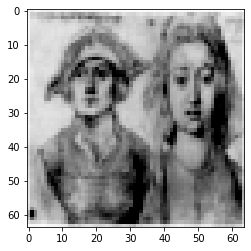

In [ ]:
images,_ = train_ds[382]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


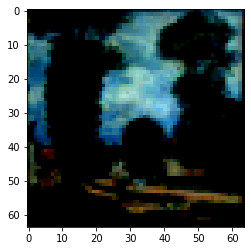

In [ ]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

In [ ]:
images,_ = train_ds[1912]
plt.imshow(images.permute(1,2,0))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

# Build the models

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

The discriminator is simply a CNN based image classifier which will output values of what it thinks is fake or real with 0 being fake and 1 being real

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 150

The generator will take in a random seed and generate an image from that seed, upsampling as much as needed. Note that increasing resolution will require retuning of the models as well as increase training time by a lot. I found that the generator needs to have quite a lot of capacity in order to keep up with the discriminator at later stages of training.

architecture based on the findings and guidelines proposed in the paper:

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

Further increasing conv layers will lead to mode collapse from what I've tr

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Training the model

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Here we use the untrained generator to generate an image (which will be very random)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


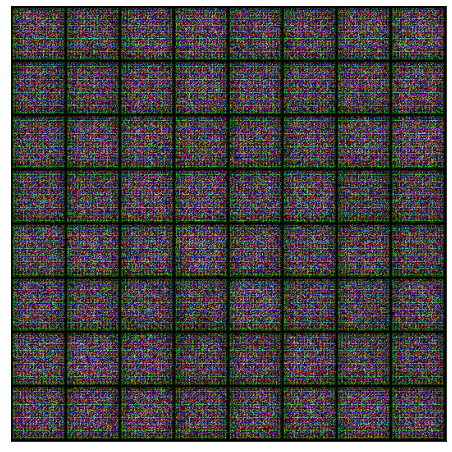

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 7.4MB/s 


In [ ]:
lr = 0.001
epochs = 150

Run the Epochs

In [ ]:
history = fit(epochs,lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/150], loss_g: 3.3250, loss_d: 0.2714, real_score: 0.9194, fake_score: 0.1625
Saving generated-images-0001.png



Epoch [2/150], loss_g: 2.0519, loss_d: 0.8250, real_score: 0.7499, fake_score: 0.3907
Saving generated-images-0002.png



Epoch [3/150], loss_g: 1.0720, loss_d: 1.0218, real_score: 0.6067, fake_score: 0.2867
Saving generated-images-0003.png



Epoch [4/150], loss_g: 1.9000, loss_d: 1.2400, real_score: 0.5617, fake_score: 0.4148
Saving generated-images-0004.png



Epoch [5/150], loss_g: 1.6530, loss_d: 1.0818, real_score: 0.6120, fake_score: 0.3779
Saving generated-images-0005.png



Epoch [6/150], loss_g: 1.6131, loss_d: 1.0685, real_score: 0.5649, fake_score: 0.3515
Saving generated-images-0006.png



Epoch [7/150], loss_g: 3.9746, loss_d: 1.4492, real_score: 0.5979, fake_score: 0.5586
Saving generated-images-0007.png



Epoch [8/150], loss_g: 1.1072, loss_d: 1.7399, real_score: 0.2655, fake_score: 0.1419
Saving generated-images-0008.png



Epoch [9/150], loss_g: 0.8505, loss_d: 1.3276, real_score: 0.3320, fake_score: 0.1265
Saving generated-images-0009.png



Epoch [10/150], loss_g: 0.7286, loss_d: 1.4164, real_score: 0.3456, fake_score: 0.2031
Saving generated-images-0010.png



Epoch [11/150], loss_g: 1.7456, loss_d: 0.9067, real_score: 0.5739, fake_score: 0.2676
Saving generated-images-0011.png



Epoch [12/150], loss_g: 1.7769, loss_d: 1.0835, real_score: 0.6404, fake_score: 0.3909
Saving generated-images-0012.png



Epoch [13/150], loss_g: 1.6920, loss_d: 0.8413, real_score: 0.7380, fake_score: 0.3676
Saving generated-images-0013.png



Epoch [14/150], loss_g: 2.3418, loss_d: 0.7747, real_score: 0.7362, fake_score: 0.3454
Saving generated-images-0014.png



Epoch [15/150], loss_g: 1.4538, loss_d: 1.5429, real_score: 0.2987, fake_score: 0.1221
Saving generated-images-0015.png



Epoch [16/150], loss_g: 1.8124, loss_d: 1.0111, real_score: 0.7969, fake_score: 0.5099
Saving generated-images-0016.png



Epoch [17/150], loss_g: 2.1667, loss_d: 0.7768, real_score: 0.6093, fake_score: 0.2018
Saving generated-images-0017.png



Epoch [18/150], loss_g: 2.0171, loss_d: 2.1992, real_score: 0.2079, fake_score: 0.0667
Saving generated-images-0018.png



Epoch [19/150], loss_g: 1.8133, loss_d: 0.8627, real_score: 0.6123, fake_score: 0.2304
Saving generated-images-0019.png



Epoch [20/150], loss_g: 2.8673, loss_d: 0.4409, real_score: 0.8037, fake_score: 0.1702
Saving generated-images-0020.png



Epoch [21/150], loss_g: 4.0893, loss_d: 0.8728, real_score: 0.8572, fake_score: 0.4798
Saving generated-images-0021.png



Epoch [22/150], loss_g: 4.4028, loss_d: 1.2915, real_score: 0.8588, fake_score: 0.6473
Saving generated-images-0022.png



Epoch [23/150], loss_g: 1.9709, loss_d: 0.8279, real_score: 0.6631, fake_score: 0.3077
Saving generated-images-0023.png



Epoch [24/150], loss_g: 4.3820, loss_d: 1.0324, real_score: 0.8674, fake_score: 0.5448
Saving generated-images-0024.png



Epoch [25/150], loss_g: 1.3981, loss_d: 0.9482, real_score: 0.4836, fake_score: 0.1185
Saving generated-images-0025.png



Epoch [26/150], loss_g: 2.7689, loss_d: 0.6793, real_score: 0.7167, fake_score: 0.2526
Saving generated-images-0026.png



Epoch [27/150], loss_g: 2.4181, loss_d: 0.7069, real_score: 0.6689, fake_score: 0.2177
Saving generated-images-0027.png



Epoch [28/150], loss_g: 3.8056, loss_d: 0.6406, real_score: 0.8447, fake_score: 0.3248
Saving generated-images-0028.png



Epoch [29/150], loss_g: 4.1425, loss_d: 0.9836, real_score: 0.8740, fake_score: 0.5153
Saving generated-images-0029.png



Epoch [30/150], loss_g: 1.9054, loss_d: 1.1350, real_score: 0.5557, fake_score: 0.3213
Saving generated-images-0030.png



Epoch [31/150], loss_g: 1.2959, loss_d: 1.5414, real_score: 0.3855, fake_score: 0.1632
Saving generated-images-0031.png



Epoch [32/150], loss_g: 3.9859, loss_d: 1.1695, real_score: 0.6263, fake_score: 0.4079
Saving generated-images-0032.png



Epoch [33/150], loss_g: 3.7795, loss_d: 0.8524, real_score: 0.8920, fake_score: 0.4767
Saving generated-images-0033.png



Epoch [34/150], loss_g: 3.0745, loss_d: 0.7605, real_score: 0.8497, fake_score: 0.3824
Saving generated-images-0034.png



Epoch [35/150], loss_g: 4.6313, loss_d: 1.0344, real_score: 0.9265, fake_score: 0.5278
Saving generated-images-0035.png



Epoch [36/150], loss_g: 0.9727, loss_d: 1.4206, real_score: 0.3404, fake_score: 0.0562
Saving generated-images-0036.png



Epoch [37/150], loss_g: 3.3258, loss_d: 0.7957, real_score: 0.7066, fake_score: 0.2743
Saving generated-images-0037.png



Epoch [38/150], loss_g: 6.2502, loss_d: 1.2937, real_score: 0.8846, fake_score: 0.6026
Saving generated-images-0038.png



Epoch [39/150], loss_g: 3.6209, loss_d: 0.4067, real_score: 0.7720, fake_score: 0.1130
Saving generated-images-0039.png



Epoch [40/150], loss_g: 2.1644, loss_d: 0.7010, real_score: 0.7269, fake_score: 0.2682
Saving generated-images-0040.png



Epoch [41/150], loss_g: 4.7702, loss_d: 0.5968, real_score: 0.9211, fake_score: 0.3552
Saving generated-images-0041.png



Epoch [42/150], loss_g: 2.3768, loss_d: 0.8215, real_score: 0.7410, fake_score: 0.3205
Saving generated-images-0042.png



Epoch [43/150], loss_g: 1.9893, loss_d: 0.6050, real_score: 0.7279, fake_score: 0.1713
Saving generated-images-0043.png



Epoch [44/150], loss_g: 4.4067, loss_d: 1.0828, real_score: 0.8584, fake_score: 0.5225
Saving generated-images-0044.png



Epoch [45/150], loss_g: 3.3891, loss_d: 1.1628, real_score: 0.8253, fake_score: 0.5244
Saving generated-images-0045.png



Epoch [46/150], loss_g: 1.5435, loss_d: 1.2256, real_score: 0.4461, fake_score: 0.1560
Saving generated-images-0046.png



Epoch [47/150], loss_g: 1.7636, loss_d: 0.8831, real_score: 0.6636, fake_score: 0.2829
Saving generated-images-0047.png



Epoch [48/150], loss_g: 2.1342, loss_d: 1.3229, real_score: 0.5405, fake_score: 0.3368
Saving generated-images-0048.png



Epoch [49/150], loss_g: 2.3839, loss_d: 0.7966, real_score: 0.6196, fake_score: 0.1584
Saving generated-images-0049.png



Epoch [50/150], loss_g: 1.8671, loss_d: 0.8010, real_score: 0.6368, fake_score: 0.2006
Saving generated-images-0050.png



Epoch [51/150], loss_g: 5.5921, loss_d: 1.1114, real_score: 0.9294, fake_score: 0.5876
Saving generated-images-0051.png



Epoch [52/150], loss_g: 1.0138, loss_d: 1.2579, real_score: 0.4038, fake_score: 0.1428
Saving generated-images-0052.png



Epoch [53/150], loss_g: 5.6039, loss_d: 1.2623, real_score: 0.9320, fake_score: 0.6072
Saving generated-images-0053.png



Epoch [54/150], loss_g: 2.8553, loss_d: 0.6192, real_score: 0.6479, fake_score: 0.0466
Saving generated-images-0054.png



Epoch [55/150], loss_g: 4.7163, loss_d: 1.2765, real_score: 0.9240, fake_score: 0.6188
Saving generated-images-0055.png



Epoch [56/150], loss_g: 4.1202, loss_d: 0.6614, real_score: 0.9326, fake_score: 0.3838
Saving generated-images-0056.png



Epoch [57/150], loss_g: 3.6022, loss_d: 0.4364, real_score: 0.7172, fake_score: 0.0574
Saving generated-images-0057.png



Epoch [58/150], loss_g: 3.5019, loss_d: 0.7036, real_score: 0.7570, fake_score: 0.2857
Saving generated-images-0058.png



Epoch [59/150], loss_g: 4.1287, loss_d: 0.6024, real_score: 0.8466, fake_score: 0.3026
Saving generated-images-0059.png



Epoch [60/150], loss_g: 3.8143, loss_d: 0.5765, real_score: 0.8777, fake_score: 0.3069
Saving generated-images-0060.png



Epoch [61/150], loss_g: 3.8901, loss_d: 0.7479, real_score: 0.9683, fake_score: 0.4327
Saving generated-images-0061.png



Epoch [62/150], loss_g: 4.6165, loss_d: 0.9609, real_score: 0.9016, fake_score: 0.5078
Saving generated-images-0062.png



Epoch [63/150], loss_g: 4.4363, loss_d: 0.5994, real_score: 0.8496, fake_score: 0.2731
Saving generated-images-0063.png



Epoch [64/150], loss_g: 3.4402, loss_d: 0.4331, real_score: 0.7396, fake_score: 0.0812
Saving generated-images-0064.png



Epoch [65/150], loss_g: 3.1768, loss_d: 0.3658, real_score: 0.9070, fake_score: 0.2061
Saving generated-images-0065.png



Epoch [66/150], loss_g: 6.1452, loss_d: 1.3113, real_score: 0.9197, fake_score: 0.6203
Saving generated-images-0066.png



Epoch [67/150], loss_g: 3.4486, loss_d: 0.8410, real_score: 0.8277, fake_score: 0.3938
Saving generated-images-0067.png



Epoch [68/150], loss_g: 2.5127, loss_d: 0.5246, real_score: 0.7623, fake_score: 0.1747
Saving generated-images-0068.png



Epoch [69/150], loss_g: 3.3829, loss_d: 0.4989, real_score: 0.8052, fake_score: 0.1802
Saving generated-images-0069.png



Epoch [70/150], loss_g: 4.2147, loss_d: 0.5856, real_score: 0.8294, fake_score: 0.2699
Saving generated-images-0070.png



Epoch [71/150], loss_g: 3.3652, loss_d: 0.6949, real_score: 0.8135, fake_score: 0.3067
Saving generated-images-0071.png



Epoch [72/150], loss_g: 3.8210, loss_d: 0.3556, real_score: 0.8376, fake_score: 0.1297
Saving generated-images-0072.png



Epoch [73/150], loss_g: 4.7318, loss_d: 0.9792, real_score: 0.9420, fake_score: 0.4963
Saving generated-images-0073.png



Epoch [74/150], loss_g: 2.1791, loss_d: 0.6946, real_score: 0.6905, fake_score: 0.1708
Saving generated-images-0074.png



Epoch [75/150], loss_g: 4.0674, loss_d: 0.5003, real_score: 0.9210, fake_score: 0.2660
Saving generated-images-0075.png



Epoch [76/150], loss_g: 3.7680, loss_d: 0.3181, real_score: 0.9264, fake_score: 0.1719
Saving generated-images-0076.png



Epoch [77/150], loss_g: 4.1519, loss_d: 0.3952, real_score: 0.9117, fake_score: 0.2155
Saving generated-images-0077.png



Epoch [78/150], loss_g: 3.0722, loss_d: 0.5760, real_score: 0.7389, fake_score: 0.1418
Saving generated-images-0078.png



Epoch [79/150], loss_g: 2.9773, loss_d: 0.4873, real_score: 0.7846, fake_score: 0.1521
Saving generated-images-0079.png



Epoch [80/150], loss_g: 4.2210, loss_d: 0.5995, real_score: 0.9358, fake_score: 0.3367
Saving generated-images-0080.png



Epoch [81/150], loss_g: 2.2373, loss_d: 0.4735, real_score: 0.7189, fake_score: 0.0730
Saving generated-images-0081.png



Epoch [82/150], loss_g: 3.8771, loss_d: 0.2044, real_score: 0.9947, fake_score: 0.1601
Saving generated-images-0082.png



Epoch [83/150], loss_g: 3.7030, loss_d: 0.4350, real_score: 0.9677, fake_score: 0.2604
Saving generated-images-0083.png



Epoch [84/150], loss_g: 5.9319, loss_d: 1.1093, real_score: 0.9197, fake_score: 0.5008
Saving generated-images-0084.png



Epoch [85/150], loss_g: 3.8612, loss_d: 0.3352, real_score: 0.8206, fake_score: 0.0764
Saving generated-images-0085.png



Epoch [86/150], loss_g: 4.8495, loss_d: 0.8470, real_score: 0.9419, fake_score: 0.3724
Saving generated-images-0086.png



Epoch [87/150], loss_g: 3.1109, loss_d: 0.3737, real_score: 0.8594, fake_score: 0.1414
Saving generated-images-0087.png



Epoch [88/150], loss_g: 4.4817, loss_d: 0.3159, real_score: 0.9241, fake_score: 0.1440
Saving generated-images-0088.png



Epoch [89/150], loss_g: 3.5549, loss_d: 0.3500, real_score: 0.8392, fake_score: 0.1081
Saving generated-images-0089.png



Epoch [90/150], loss_g: 4.0865, loss_d: 0.1688, real_score: 0.9470, fake_score: 0.0893
Saving generated-images-0090.png



Epoch [91/150], loss_g: 6.2979, loss_d: 0.6091, real_score: 0.9809, fake_score: 0.3481
Saving generated-images-0091.png



Epoch [92/150], loss_g: 4.7514, loss_d: 0.5374, real_score: 0.9402, fake_score: 0.2895
Saving generated-images-0092.png



Epoch [93/150], loss_g: 2.2488, loss_d: 0.9822, real_score: 0.5032, fake_score: 0.0083
Saving generated-images-0093.png



Epoch [94/150], loss_g: 3.3029, loss_d: 0.3023, real_score: 0.8424, fake_score: 0.0645
Saving generated-images-0094.png



Epoch [95/150], loss_g: 5.0615, loss_d: 0.0890, real_score: 0.9716, fake_score: 0.0528
Saving generated-images-0095.png



Epoch [96/150], loss_g: 3.3724, loss_d: 0.2674, real_score: 0.9233, fake_score: 0.1418
Saving generated-images-0096.png



Epoch [97/150], loss_g: 5.1531, loss_d: 0.1054, real_score: 0.9570, fake_score: 0.0483
Saving generated-images-0097.png



Epoch [98/150], loss_g: 5.3013, loss_d: 0.4119, real_score: 0.8703, fake_score: 0.1463
Saving generated-images-0098.png



Epoch [99/150], loss_g: 3.7721, loss_d: 0.4244, real_score: 0.8616, fake_score: 0.1796
Saving generated-images-0099.png



Epoch [100/150], loss_g: 5.2771, loss_d: 0.1633, real_score: 0.9821, fake_score: 0.1192
Saving generated-images-0100.png



Epoch [101/150], loss_g: 4.5539, loss_d: 0.5191, real_score: 0.9694, fake_score: 0.3087
Saving generated-images-0101.png



Epoch [102/150], loss_g: 5.0299, loss_d: 0.1342, real_score: 0.9287, fake_score: 0.0372
Saving generated-images-0102.png



Epoch [103/150], loss_g: 5.2837, loss_d: 0.0661, real_score: 0.9984, fake_score: 0.0587
Saving generated-images-0103.png



Epoch [104/150], loss_g: 9.2359, loss_d: 2.1941, real_score: 0.9400, fake_score: 0.7004
Saving generated-images-0104.png



Epoch [105/150], loss_g: 5.6829, loss_d: 0.2038, real_score: 0.9864, fake_score: 0.1285
Saving generated-images-0105.png



Epoch [106/150], loss_g: 6.2612, loss_d: 0.1657, real_score: 0.9815, fake_score: 0.1035
Saving generated-images-0106.png



Epoch [107/150], loss_g: 4.6925, loss_d: 0.1117, real_score: 0.9485, fake_score: 0.0477
Saving generated-images-0107.png



Epoch [108/150], loss_g: 5.8739, loss_d: 0.0930, real_score: 0.9995, fake_score: 0.0818
Saving generated-images-0108.png



Epoch [109/150], loss_g: 7.2479, loss_d: 0.5269, real_score: 0.9969, fake_score: 0.3181
Saving generated-images-0109.png



Epoch [110/150], loss_g: 3.9531, loss_d: 0.1934, real_score: 0.8807, fake_score: 0.0447
Saving generated-images-0110.png



Epoch [111/150], loss_g: 4.1228, loss_d: 0.1130, real_score: 0.9529, fake_score: 0.0483
Saving generated-images-0111.png



Epoch [112/150], loss_g: 4.1842, loss_d: 0.7473, real_score: 0.7703, fake_score: 0.2362
Saving generated-images-0112.png



Epoch [113/150], loss_g: 4.7411, loss_d: 0.2229, real_score: 0.8920, fake_score: 0.0580
Saving generated-images-0113.png



Epoch [114/150], loss_g: 5.7165, loss_d: 0.0702, real_score: 0.9761, fake_score: 0.0403
Saving generated-images-0114.png



Epoch [115/150], loss_g: 5.2734, loss_d: 0.1036, real_score: 0.9585, fake_score: 0.0526
Saving generated-images-0115.png



Epoch [116/150], loss_g: 6.2528, loss_d: 0.2900, real_score: 0.9311, fake_score: 0.1578
Saving generated-images-0116.png



Epoch [117/150], loss_g: 1.2899, loss_d: 0.7632, real_score: 0.5752, fake_score: 0.0040
Saving generated-images-0117.png



Epoch [118/150], loss_g: 2.4441, loss_d: 1.0256, real_score: 0.5199, fake_score: 0.0023
Saving generated-images-0118.png



Epoch [119/150], loss_g: 5.6036, loss_d: 0.1460, real_score: 0.9454, fake_score: 0.0683
Saving generated-images-0119.png



Epoch [120/150], loss_g: 4.8932, loss_d: 0.1387, real_score: 0.9121, fake_score: 0.0320
Saving generated-images-0120.png



Epoch [121/150], loss_g: 5.3144, loss_d: 0.1330, real_score: 0.9308, fake_score: 0.0409
Saving generated-images-0121.png



Epoch [122/150], loss_g: 2.7681, loss_d: 0.4073, real_score: 0.7516, fake_score: 0.0529
Saving generated-images-0122.png



Epoch [123/150], loss_g: 5.0420, loss_d: 0.1831, real_score: 0.8900, fake_score: 0.0391
Saving generated-images-0123.png



Epoch [124/150], loss_g: 3.3334, loss_d: 0.2555, real_score: 0.8499, fake_score: 0.0383
Saving generated-images-0124.png



Epoch [125/150], loss_g: 0.0254, loss_d: 3.9362, real_score: 0.1837, fake_score: 0.0320
Saving generated-images-0125.png



Epoch [126/150], loss_g: 4.7568, loss_d: 0.4409, real_score: 0.9943, fake_score: 0.2381
Saving generated-images-0126.png



Epoch [127/150], loss_g: 6.8488, loss_d: 0.3405, real_score: 0.9914, fake_score: 0.1884
Saving generated-images-0127.png



Epoch [128/150], loss_g: 4.8890, loss_d: 0.0606, real_score: 0.9923, fake_score: 0.0466
Saving generated-images-0128.png



Epoch [129/150], loss_g: 6.0941, loss_d: 0.2280, real_score: 0.8370, fake_score: 0.0036
Saving generated-images-0129.png



Epoch [130/150], loss_g: 4.0970, loss_d: 0.2494, real_score: 0.8412, fake_score: 0.0126
Saving generated-images-0130.png



Epoch [131/150], loss_g: 6.5293, loss_d: 0.1514, real_score: 0.9983, fake_score: 0.0854
Saving generated-images-0131.png



Epoch [132/150], loss_g: 5.7379, loss_d: 0.0760, real_score: 0.9589, fake_score: 0.0253
Saving generated-images-0132.png



Epoch [133/150], loss_g: 7.9963, loss_d: 0.0886, real_score: 0.9975, fake_score: 0.0651
Saving generated-images-0133.png



Epoch [134/150], loss_g: 4.4921, loss_d: 0.1575, real_score: 0.9042, fake_score: 0.0164
Saving generated-images-0134.png



Epoch [135/150], loss_g: 7.2182, loss_d: 0.3573, real_score: 0.9742, fake_score: 0.1942
Saving generated-images-0135.png



Epoch [136/150], loss_g: 6.0820, loss_d: 0.1631, real_score: 0.9671, fake_score: 0.0859
Saving generated-images-0136.png



Epoch [137/150], loss_g: 4.5674, loss_d: 0.2206, real_score: 0.8676, fake_score: 0.0337
Saving generated-images-0137.png



Epoch [138/150], loss_g: 2.4585, loss_d: 0.4707, real_score: 0.7330, fake_score: 0.0142
Saving generated-images-0138.png



Epoch [139/150], loss_g: 5.3089, loss_d: 0.0529, real_score: 0.9839, fake_score: 0.0315
Saving generated-images-0139.png



Epoch [140/150], loss_g: 6.2561, loss_d: 0.0589, real_score: 0.9569, fake_score: 0.0077
Saving generated-images-0140.png



Epoch [141/150], loss_g: 7.6221, loss_d: 0.0287, real_score: 0.9754, fake_score: 0.0027
Saving generated-images-0141.png



Epoch [142/150], loss_g: 4.8088, loss_d: 0.1386, real_score: 0.9186, fake_score: 0.0331
Saving generated-images-0142.png



Epoch [143/150], loss_g: 6.9946, loss_d: 0.1236, real_score: 0.9105, fake_score: 0.0101
Saving generated-images-0143.png



Epoch [144/150], loss_g: 5.3251, loss_d: 0.0871, real_score: 0.9887, fake_score: 0.0645
Saving generated-images-0144.png



Epoch [145/150], loss_g: 1.2898, loss_d: 1.1153, real_score: 0.6276, fake_score: 0.1598
Saving generated-images-0145.png



Epoch [146/150], loss_g: 5.8839, loss_d: 0.2681, real_score: 0.9847, fake_score: 0.1422
Saving generated-images-0146.png



Epoch [147/150], loss_g: 5.0459, loss_d: 0.2069, real_score: 0.8544, fake_score: 0.0184
Saving generated-images-0147.png



Epoch [148/150], loss_g: 6.0683, loss_d: 0.3456, real_score: 0.9971, fake_score: 0.1778
Saving generated-images-0148.png



Epoch [149/150], loss_g: 5.4299, loss_d: 0.0896, real_score: 0.9390, fake_score: 0.0188
Saving generated-images-0149.png



Epoch [150/150], loss_g: 4.6944, loss_d: 0.1270, real_score: 0.9631, fake_score: 0.0710
Saving generated-images-0150.png


In [ ]:
from IPython.display import Image 

WOW lets see the output !!

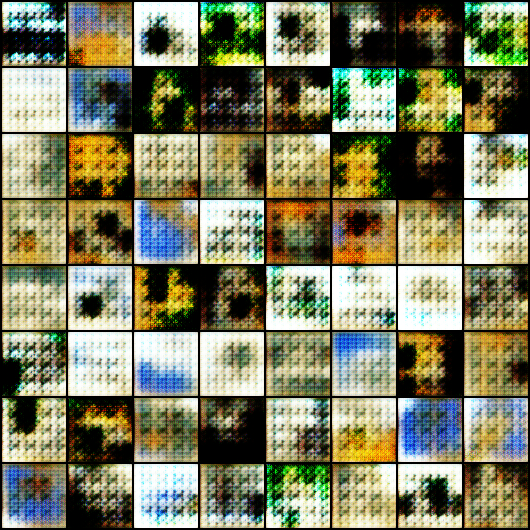

In [ ]:
Image('./generated/generated-images-0013.png')

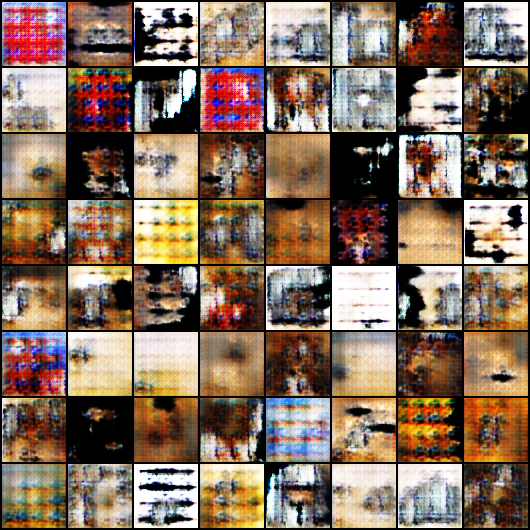

In [ ]:
Image('./generated/generated-images-0037.png')

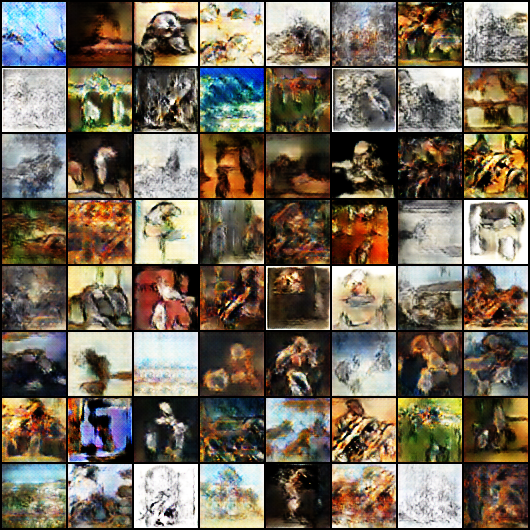

In [ ]:
Image('./generated/generated-images-0072.png')

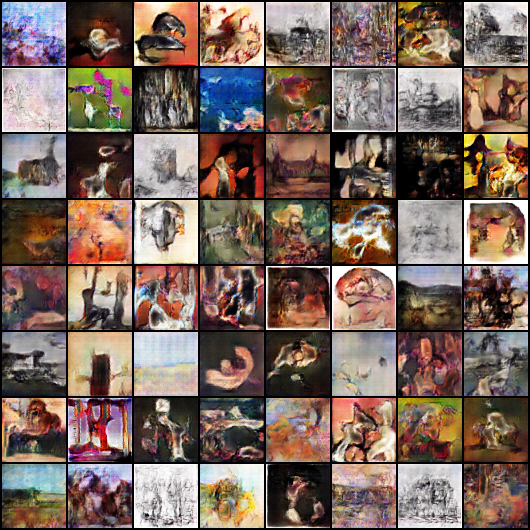

In [ ]:
Image('./generated/generated-images-0103.png')

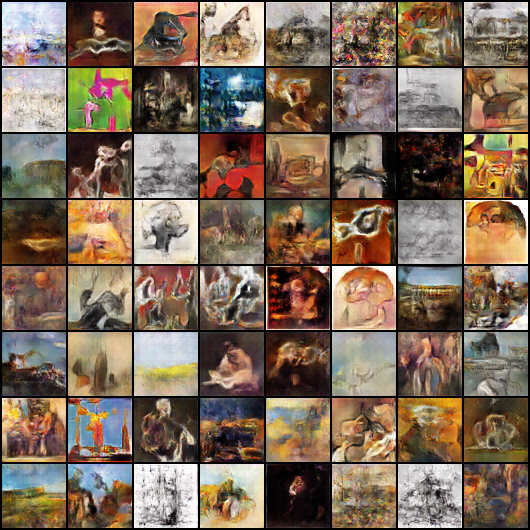

In [ ]:
Image('./generated/generated-images-0138.png')

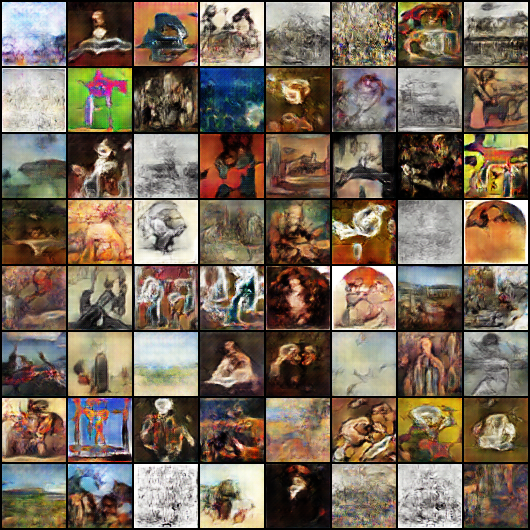

In [ ]:
Image('./generated/generated-images-0147.png')

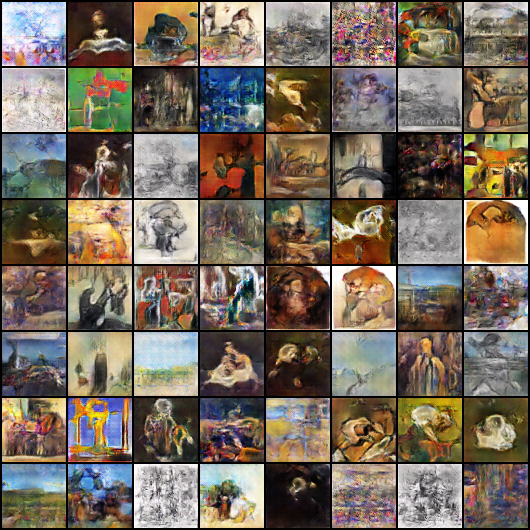

In [ ]:
Image('./generated/generated-images-0150.png')

Lets plot our losses and epochs, score and epochs

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

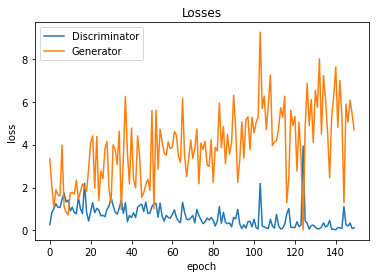

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

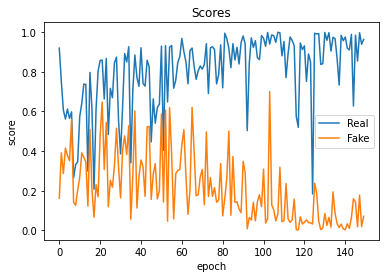

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Lets convert our output images from each epoch to a video file, we have done this only for the pytorch model cos this model runs only 150 epochs

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Thats pretty much it !